In [1]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score)
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_sleep_data(data_dir):                                              # Sleep-EDF icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                          # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('0-PSG.edf'):
            hyp_file = f.replace('0-PSG.edf', 'C-Hypnogram.edf')
            if os.path.exists(os.path.join(data_dir, hyp_file)):            # Ayni konuya ait PSG ve Hypnogram dosyalarini eslestiriyoruz.
                file_pairs.append((                                         # PSG dosyasi sinyalleri tutar ve Hypnogram dosyasi labellari tutar.
                    os.path.join(data_dir, f),
                    os.path.join(data_dir, hyp_file)
                ))
    
    print(f"Bulunan PSG-Hypnogram çiftleri: {len(file_pairs)}")
    return file_pairs

In [4]:
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, kurtosis, skew, iqr

def extract_features_multi(data, sfreq):
    feature_list = []
    count = 0
    
    # Zaman serisinde ozellik cikarimi yapiyorum. Buradaki ozniteliklerin cogunu TSFEL: Time Series Feature Extraction Library makalesinden aldim.

    for epoch in data:
        feats = []
        for ch_signal in epoch:
            t = np.arange(len(ch_signal))
            abs_energy = np.sum(ch_signal**2)                                                           # Sinyalin toplam enerjisi, guc olcusu
            area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri
            
            autocorr = np.corrcoef(ch_signal[:-1], ch_signal[1:])[0, 1] if np.std(ch_signal) > 0 else 0 # Sinyalin kendisiyle bir gecikmeyle olan korelasyonu
            
            avg_power = np.mean(ch_signal**2)                                                           # Ortalama guc
            centroid = np.sum(t * np.abs(ch_signal)) / (np.sum(np.abs(ch_signal)) + 1e-12)              # Sinyal agirlik merkezi
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)
            hist_entropy = entropy(hist + 1e-12)                                                        # Sinyal genlik dagiliminin duzensizligi
            
            freqs, psd = welch(ch_signal, sfreq, nperseg=min(256, len(ch_signal)))
            psd /= np.sum(psd) + 1e-12                                                                  # Frekanslara gore enerji dagilimi
            
            fund_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0                                    # En yuksek guce sahip frekans bileşeni
            
            hist_vals, hist_bins = np.histogram(ch_signal, bins=10)
            hist_mode = hist_bins[np.argmax(hist_vals)]                                                 # En cok gorulen genlik degeri
            
            human_energy = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])                                  # Insan EEG bandindaki enerji
            iqr_val = iqr(ch_signal)                                                                    # Sinyalin orta %50'sinin yayilimi
            kurt_val = kurtosis(ch_signal)                                                              # Carpiklik, uc deger yogunlugu
            
            max_val = np.max(ch_signal)                                                                 # Maksimum deger
            max_psd = np.max(psd)                                                                       # Maksimum guc
            max_freq = freqs[-1]                                                                         # En yuksek olculebilir frekans
            
            mean_val = np.mean(ch_signal)                                                               # Ortalama deger
            mad = np.mean(np.abs(ch_signal - mean_val))                                                 # Ortalama mutlak sapma
            mean_abs_diff = np.mean(np.abs(np.diff(ch_signal)))                                         # Komşu ornekler arasindaki ortalama mutlak fark
            mean_diff = np.mean(np.diff(ch_signal))                                                     # Komşu ornekler arasindaki ortalama fark
            
            med_val = np.median(ch_signal)                                                              # Medyan deger
            med_abs_dev = np.median(np.abs(ch_signal - med_val))                                        # Medyan mutlak sapma
            med_abs_diff = np.median(np.abs(np.diff(ch_signal)))                                        # Medyan komşu mutlak farki
            med_diff = np.median(np.diff(ch_signal))                                                    # Medyan komşu farki
            cumulative_power = np.cumsum(psd)
            med_freq = freqs[np.argmax(cumulative_power >= 0.5)] if len(psd) > 0 else 0                 # Medyan frekans
            
            min_val = np.min(ch_signal)                                                                 # Minimum deger
            
            diff_signal = np.diff(ch_signal)
            sign_changes = np.diff(np.sign(diff_signal))
            neg_turning = np.sum(sign_changes > 0)                                                      # Negatif egimden pozitif egime geciş sayisi
            pos_turning = np.sum(sign_changes < 0)                                                      # Pozitif egimden negatif egime geciş sayisi
            peaks, _ = find_peaks(ch_signal)
            n_peaks = len(peaks)                                                                        # Tepe sayisi
            peak_dist = np.mean(np.diff(peaks)) if n_peaks > 1 else 0                                   # Tepeler arasi ortalama mesafe
            
            if len(psd) > 0:
                peak_psd = np.max(psd)
                mask = psd >= (peak_psd / 2)
                try:
                    power_bandwidth = freqs[mask][-1] - freqs[mask][0]                                  # Gucun %50'sinden fazlasini iceren frekans araligi
                except:
                    power_bandwidth = 0
            else:
                power_bandwidth = 0
                
            rms = np.sqrt(avg_power)                                                                    
            signal_dist = np.sum(np.abs(ch_signal))                                                     # Mutlak genlik toplami
            skew_val = skew(ch_signal)                                                                  # Simetri olcusu
            slope = np.polyfit(t, ch_signal, 1)[0]                                                      # Lineer egim, trend
            
            spec_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-12)                                 # Spektral agirlik merkezi
            spec_decrease = np.sum((psd[1:] - psd[0]) / np.arange(1, len(psd))) / (np.sum(psd[1:]) + 1e-12) if len(psd) > 1 else 0   # Yuksek frekanslardaki guc kaybi
            spec_ent = entropy(psd + 1e-12)                                                             # Spektral entropi
            spec_kurt = kurtosis(psd)                                                                   # Spektral carpiklik
            diff_psd = np.diff(psd)
            psd_sign_changes = np.diff(np.sign(diff_psd))
            spec_pos_turning = np.sum(psd_sign_changes < 0)                                             # Spektral donuş noktasi sayisi
            spec_roll_off = freqs[np.argmax(cumulative_power >= 0.85)] if len(psd) > 0 else 0           # Enerjinin %85'ine ulaşilan frekans
            spec_roll_on = freqs[np.argmax(cumulative_power >= 0.05)] if len(psd) > 0 else 0            # Enerjinin %5'ine ulaşilan frekans
            spec_skew = skew(psd)                                                                       # Spektral skewness
            spec_slope = np.polyfit(freqs, psd, 1)[0] if len(psd) > 1 else 0                            # Spektral egim
            spec_spread = np.sqrt(np.sum(psd * (freqs - spec_centroid)**2) / (np.sum(psd) + 1e-12))     # Spektral yayilma
            
            std = np.std(ch_signal)                                                                     # Standart sapma
            sum_abs_diff = np.sum(np.abs(np.diff(ch_signal)))                                           # Ornekler arasi toplam fark
            var = np.var(ch_signal)                                                                     # Varyans
            
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            zcr = zero_crossings / len(ch_signal)                                                       # Sinyalin kac kez sifiri gectigi
            
            features = [
                abs_energy, area_curve, autocorr, avg_power, centroid, hist_entropy,
                fund_freq, hist_mode, human_energy, iqr_val, kurt_val, max_val,
                max_psd, max_freq, mean_val, mad, mean_abs_diff, mean_diff, med_val,
                med_abs_dev, med_abs_diff, med_diff, med_freq, min_val, neg_turning,
                n_peaks, peak_dist, pos_turning, power_bandwidth, rms, signal_dist,
                skew_val, slope, spec_centroid, spec_decrease, spec_ent,
                spec_kurt, spec_pos_turning, spec_roll_off, spec_roll_on, spec_skew,
                spec_slope, spec_spread, std, sum_abs_diff, var, zcr
            ]
            
            feats.extend(features)
            
        feature_list.append(feats)
        count += 1
        
    print(f"ozellik cikarimi icin toplam {count} epoch işlendi.")
    return np.array(feature_list)

In [5]:
def create_dataset(file_pairs, epoch_duration=45.0):
    event_id = {
        'Sleep stage W': 0,                                                 # Uyanık
        'Sleep stage 1': 1,                                                 # Hafif Uyku
        'Sleep stage 2': 2,                                                 # Orta Uyku
        'Sleep stage 3': 3,                                                 # Derin Uyku
        'Sleep stage 4': 3,                                                 # Derin Uyku
        'Sleep stage R': 4                                                  # REM
    }
    X_list, y_list, meta_list = [], [], []

    for psg_file, hyp_file in file_pairs:                                           # Her PSG-Hypnogram dosya cifti icin yukleme dongusu
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annots = mne.read_annotations(hyp_file)
        raw.set_annotations(annots, emit_warning=False)

        events, found_event_id = mne.events_from_annotations(                       # Anotasyonlardan epoch eventlerini olusturuyorum.
            raw, event_id=event_id, 
            chunk_duration=epoch_duration
        )
        if len(events) == 0:
            continue

        epochs = mne.Epochs(
            raw, events, event_id=found_event_id,
            tmin=0.0, 
            tmax=epoch_duration - 1/raw.info['sfreq'],                               # Her epochun sonu           
            baseline=None, preload=True
        )
        data = epochs.get_data()                                                    # Her epoch icin ozellik cikariyorum ve ozellikleri ve etiketleri listeye ekliyorum.
        feats = extract_features_multi(data, raw.info['sfreq'])

        X_list.append(feats)
        y_list.append(epochs.events[:, -1])

        meta_list.append({
            'file': os.path.basename(psg_file),
            'n_epochs': feats.shape[0]
        })

    X = np.vstack(X_list)                                                           # Tum dosyalarin ozelliklerini ve etiketlerini birlestiriyorum.
    y = np.hstack(y_list)
    return X, y, meta_list


In [6]:
def evaluate_model(y_true, y_pred, name):                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                       # Cohen Kappa skoru
        
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred,target_names=['Wake', 'N1', 'N2', 'N3', 'REM']))
        
    cm = confusion_matrix(y_true, y_pred)                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.yticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
        
    return acc, f1, kappa
    

def train_rf_model(X_train, y_train, X_test, y_test):                               # Random Forest egitimi
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)                                                        # Model egitimi ve tahmini.
    rf_pred = rf.predict(X_test)

    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")                   # Modelin basarimini hesapliyorum.
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)          # Modelin ozelliklerinin onem grafigini cikartiyorum.
    plt.title('Random Forest - Özellik Önemleri')
    plt.xlabel('Önem Skoru')
    plt.tight_layout()
    plt.show()

    return rf,rf_metrics

def train_xgb_model(X_train, y_train, X_test, y_test):                              # XGBoost modeli egitimi

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)                                                 # Model egitimi ve tahmini.
    xgb_pred = xgb_model.predict(X_test)

    xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
    

    return xgb_model,xgb_metrics


def train_mlp_model(X_train, y_train, X_test, y_test):                              # Bir multi layer perceptron kullandim.
    model = Sequential([                                                            # 3 gizli katman ve Dropout ile tanimladim.
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(5, activation='softmax')
    ])
    
    model.compile(                                                                  # Modeli derliyorum.
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    

    early_stop = tf.keras.callbacks.EarlyStopping(                                  # Early stopping ile dogrulama kaybi degismezse 5 epoch sonra egitimi durduruyorum.
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(                                                            # Modeli egitiyorum.
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    mlp_pred = np.argmax(model.predict(X_test), axis=1)                             # Model sonuclarini aliyoruz ve grafigini cikartiyoruz.
    mlp_metrics = evaluate_model(y_test, mlp_pred, "MLP")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.ylabel('Kayıp')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, mlp_metrics


In [7]:
def my_standard_scaler(X):              # Verilerimi 0-1 arasina standartize ediyorum.
    mean = np.mean(X, axis=0)           # Her sutunun ortalamasi
    std = np.std(X, axis=0)             # Her sutunun standart sapmasi
    X_scaled = (X - mean) / std         # Standardizasyon formulu
    return X_scaled

Bulunan PSG-Hypnogram çiftleri: 10
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 4500 original time points ...
0 bad epochs dropped
ozellik cikarimi icin toplam 1691 epoch işlendi.
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1820 events and 4500 original time points ...
0 bad epochs dropped
ozellik cikarimi icin toplam 1820 epoch işlendi.
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep 

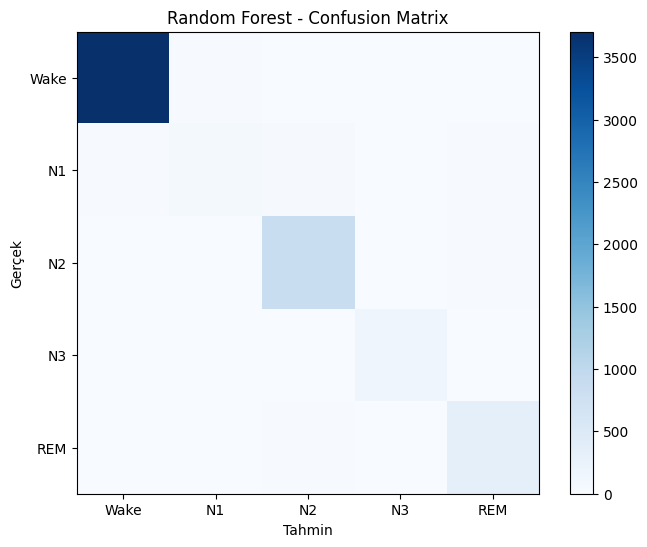

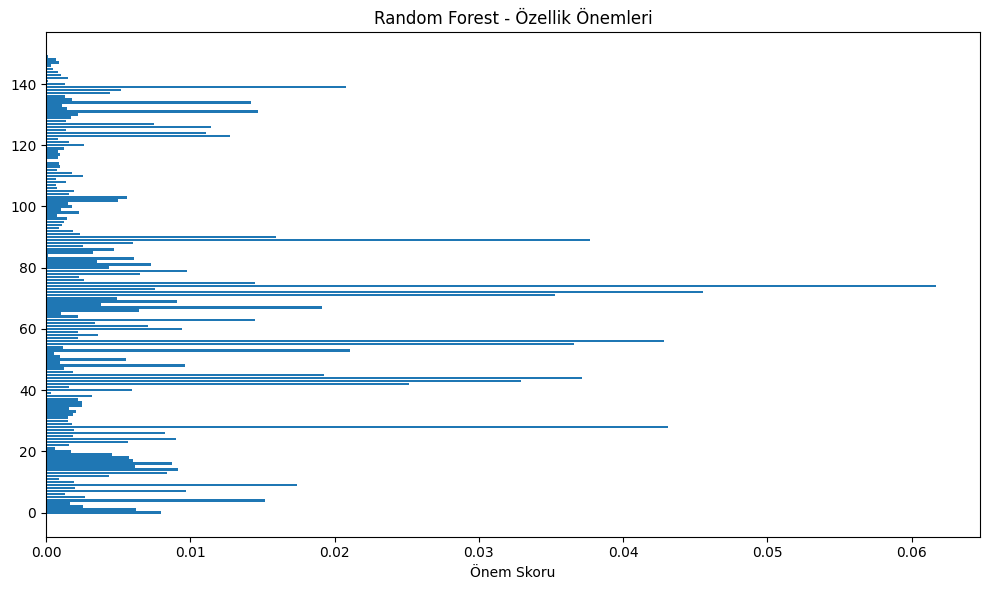


XGBoost Performans:
Accuracy: 0.9614
Macro F1: 0.8442
Cohen's Kappa: 0.9177
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.99      1.00      0.99      3726
          N1       0.65      0.39      0.49       154
          N2       0.92      0.95      0.93       910
          N3       0.93      0.91      0.92       162
         REM       0.88      0.91      0.89       361

    accuracy                           0.96      5313
   macro avg       0.87      0.83      0.84      5313
weighted avg       0.96      0.96      0.96      5313



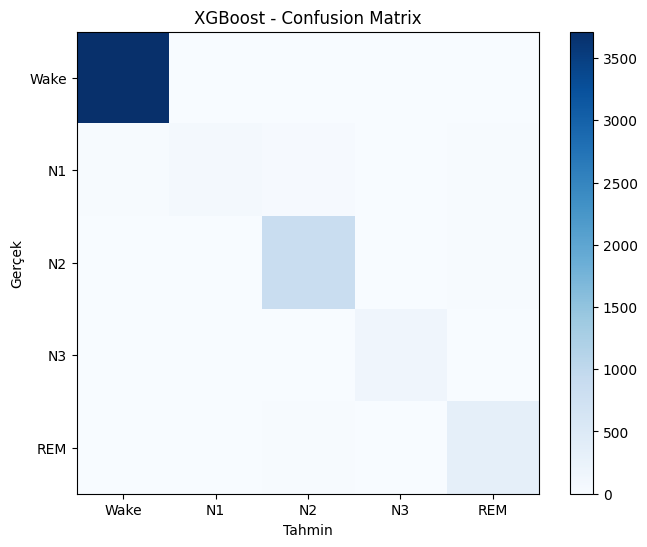

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8130 - loss: 0.5227 - val_accuracy: 0.9306 - val_loss: 0.1803
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9203 - loss: 0.2206 - val_accuracy: 0.9371 - val_loss: 0.1622
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.1761 - val_accuracy: 0.9427 - val_loss: 0.1521
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9444 - loss: 0.1563 - val_accuracy: 0.9488 - val_loss: 0.1404
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9508 - loss: 0.1395 - val_accuracy: 0.9488 - val_loss: 0.1405
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.1340 - val_accuracy: 0.9520 - val_loss: 0.1284
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1209 - val_accuracy: 0.9536 - val_loss: 0.1270
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.1302 - val_accuracy: 0.

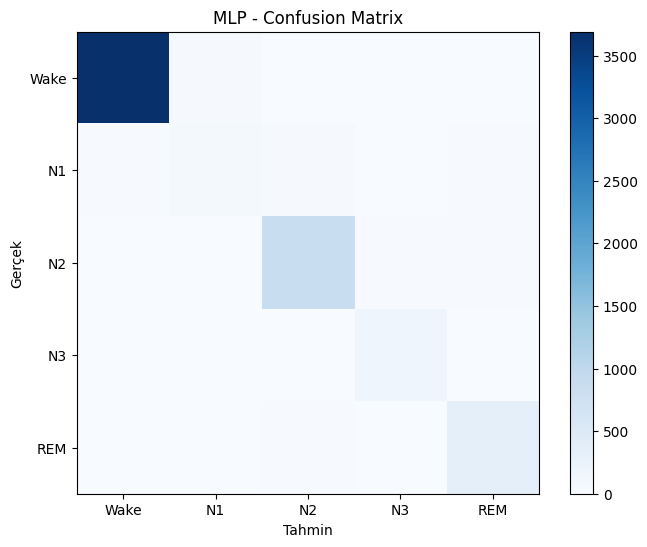

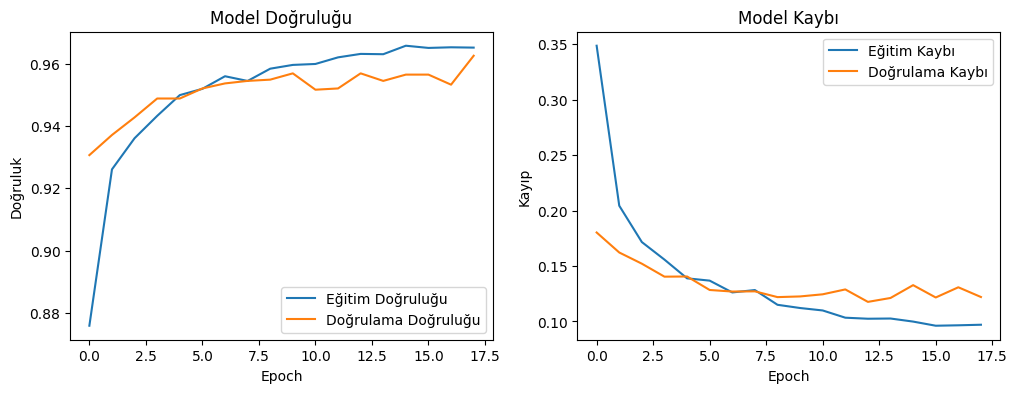

Modeller başarıyla kaydedildi!

MODEL PERFORMANS KARŞILAŞTIRMASI:
RF: Accuracy=0.9587803500846979, F1=0.8418730339883332, Kappa=0.9121678109048977
XGB: Accuracy=0.9614153961980049, F1=0.8442176463258899, Kappa=0.9176790832244958
MLP: Accuracy=0.9604743083003953, F1=0.857933495562814, Kappa=0.9165196365869848


In [8]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
def main():
    DATA_DIR = "./SleepData/Sleep_EDF_Training_Data"                                                # Egitim verisinin oldugu yer.
    
    file_pairs = load_sleep_data(DATA_DIR)                                                          # Uyku verilerini okuyoruz.
    
    X, y, metadata = create_dataset(file_pairs, epoch_duration=45.0)                                # Modelin verisetini cikartiyoruz.
    print("X shape:", getattr(X, "shape", None), "  y shape:", getattr(y, "shape", None))
    print(f"\nOluşturulan veri seti boyutu: {X.shape}")
    print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")

    X_scaled = my_standard_scaler(X)                                                                # Veriyi olceklendiriyoruz.
    
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_scaled)

    k = 150                                                                                         # 7*47 tane ozelligim var bunlarin en anlamlilarini secmeye calisiyorum.
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_imputed, y)
    selected_indices = selector.get_support(indices=True)
    print(f"Seçilen feature indeksleri: {selected_indices}")
    print("Özellik (feature) sayısı:", X_imputed.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(                                            # Egitim ve test verisini ayiriyoruz.
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )
    
    rf_model, rf_metrics = train_rf_model(X_train, y_train, X_test, y_test)                         # Modelleri egitiyoruz ve degerlendiriyoruz.
    xgb_model, xgb_metrics = train_xgb_model(X_train, y_train, X_test, y_test)
    mlp_model, mlp_metrics = train_mlp_model(X_train, y_train, X_test, y_test)

    import joblib                                                                                   # Egittigimiz modelleri kaydediyoruz. (Burayi da ChatGPT'den aldim.)
    from tensorflow.keras.models import save_model
    
    joblib.dump(imputer, 'imputer.joblib')
    joblib.dump(selector, 'selector.joblib')
    joblib.dump(rf_model, 'random_forest_model.joblib')
    joblib.dump(xgb_model, 'xgboost_model.joblib')
    mlp_model.save('mlp_model.h5')
    
    print("Modeller başarıyla kaydedildi!")

    rf_acc, rf_f1, rf_kappa = rf_metrics                                                            # En sonda toplu performans karsilastirmasi yapiyoruz.
    xgb_acc, xgb_f1, xgb_kappa = xgb_metrics
    mlp_acc, mlp_f1, mlp_kappa = mlp_metrics

    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")
    print(f"RF: Accuracy={rf_acc}, F1={rf_f1}, Kappa={rf_kappa}")
    print(f"XGB: Accuracy={xgb_acc}, F1={xgb_f1}, Kappa={xgb_kappa}")
    print(f"MLP: Accuracy={mlp_acc}, F1={mlp_f1}, Kappa={mlp_kappa}")
    
if __name__ == "__main__":
    main()